In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
)

In [3]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    search_query: str


graph_builder = StateGraph(State)

In [4]:
SYSTEM_PROMPT = """\
Based on the conversation, your task is to create a "search query" that serves \
as a query that can be used in a vector database to give most relevant information to answer the user's question.

Constrains:
- Create the search query only taking in account the conversation, avoid to add your knowledge.
"""

def rephrasor(state: State):
    ai_answer = llm.invoke([("system", SYSTEM_PROMPT)] + state["messages"])
    return {
        "search_query": ai_answer.content
    }

graph_builder.add_node("rephrasor", rephrasor)
graph_builder.set_entry_point("rephrasor")
graph_builder.set_finish_point("rephrasor")
graph = graph_builder.compile()


In [5]:
graph.invoke({"messages": [("user", "quien es susan fletcher en el libro fortaleza digital?")]})

{'messages': [HumanMessage(content='quien es susan fletcher en el libro fortaleza digital?', additional_kwargs={}, response_metadata={}, id='d7e85835-cd76-46e6-924d-253ded57f40a')],
 'search_query': 'susan fletcher personaje libro fortaleza digital'}

# Let's add the db

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    search_query: str
    context: str




In [7]:
import os
from langchain_qdrant import QdrantVectorStore
from qdrant_client import QdrantClient
from langchain_openai import OpenAIEmbeddings
from langchain_core.runnables import RunnableLambda

url = "https://e7f4684c-fd33-4db0-b1d3-268870ecb84d.europe-west3-0.gcp.cloud.qdrant.io:6333"
api_key = os.getenv("QDRANT_API_KEY")


client = QdrantClient(
    url=url,
    api_key=api_key,
    https=True,
    timeout=300
)

vector_store_page = QdrantVectorStore(
    client=client,
    collection_name="db-book-page",
    embedding=OpenAIEmbeddings(model="text-embedding-ada-002"),
)

In [8]:
from langchain_core.documents import Document
from langgraph.graph import START, END

def combine_documents(documents: list[Document]) -> str:
    return "\n\n".join([document.page_content for document in documents])


SYSTEM_PROMPT = """\
Based on the conversation, your task is to create a "search query" that serves \
as a query that can be used in a vector database to give most relevant information to answer the user's question.

Constrains:
- Create the search query only taking in account the conversation, avoid to add your knowledge.
"""

def rephrasor(state: State):
    ai_answer = llm.invoke([("system", SYSTEM_PROMPT)] + state["messages"])
    return {
        "search_query": ai_answer.content
    }

def search(state: State):

    chain = vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return {"context": chain.invoke(state["search_query"])}

graph_builder = StateGraph(State)
graph_builder.add_node("rephrasor", rephrasor)
graph_builder.add_node("search", search)

graph_builder.add_edge(START, "rephrasor")
graph_builder.add_edge("rephrasor", "search")
graph_builder.add_edge("search", END)
graph = graph_builder.compile()


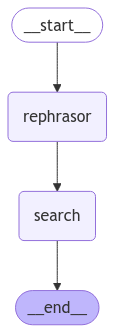

In [9]:
graph

In [ ]:
graph.invoke({"messages": [("user", "quien es susan fletcher en el libro fortaleza digital?")]})

# Let's add the chatbot

In [ ]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
from langchain_core.documents import Document
from langgraph.graph import START, END


class State(TypedDict):
    messages: Annotated[list, add_messages]
    search_query: str
    context: str


def combine_documents(documents: list[Document]) -> str:
    return "\n\n".join([document.page_content for document in documents])


REPHRASOR_SYSTEM_PROMPT = """\
Based on the conversation, your task is to create a "search query" that serves \
as a query that can be used in a vector database to give most relevant information to answer the user's question.

Constrains:
- Create the search query only taking in account the conversation, avoid to add your knowledge.
"""

def rephrasor(state: State):
    ai_answer = llm.invoke([("system", REPHRASOR_SYSTEM_PROMPT)] + state["messages"])
    return {
        "search_query": ai_answer.content
    }

def search(state: State):

    chain = vector_store_page.as_retriever(search_kwargs={"k": 5}) | RunnableLambda(combine_documents)
    return {"context": chain.invoke(state["search_query"])}

QA_SYSTEM_PROMPT = """
<PERSONA>
Eres un especialista resolviendo dudas sobre libros de ficción
</PERSONA>

<TAREA>
Tu tarea es responder la pregunta del usuario.
</TAREA>

<RESTRICCIONES>
- Solo responde la pregunta del usuario tomando como contexto lo provisto en <CONTEXTO>.
</RESTRICCIONES>

<CONTEXTO>
{context}
</CONTEXTO>

"""

def chatbot(state: State):
    ai_answer = llm.invoke([("system", QA_SYSTEM_PROMPT.format(context=state["context"]))] + state["messages"])
    return {
        "messages": [ai_answer]
    }

graph_builder = StateGraph(State)
graph_builder.add_node("rephrasor", rephrasor)
graph_builder.add_node("search", search)
graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "rephrasor")
graph_builder.add_edge("rephrasor", "search")
graph_builder.add_edge("search", "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()


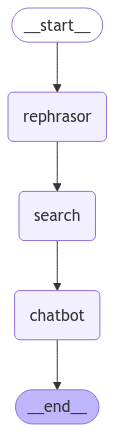

In [11]:
graph

In [10]:
graph.invoke({"messages": [("user", "quien es susan fletcher en el libro fortaleza digital?")]})

{'messages': [HumanMessage(content='quien es susan fletcher en el libro fortaleza digital?', additional_kwargs={}, response_metadata={}, id='6278768c-9ce6-4e5a-8270-c92be4fbbcd6'),
  AIMessage(content='Susan Fletcher es la criptógrafa estrella de la ultrasecreta Agencia de Seguridad Nacional (NSA) en el libro "La fortaleza digital" de Dan Brown. Ella se enfrenta a un desafío cuando interceptan un código que ni siquiera la mayor supercomputadora puede descifrar. A lo largo de la historia, Susan se ve envuelta en un drama dentro de las instalaciones de la NSA mientras intenta resolver el misterio del código y lidiar con situaciones de peligro y traición.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 99, 'prompt_tokens': 1863, 'total_tokens': 1962, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tok